# Code and Calculation Verification of Physics-informed Neural Networks (PINNs)

# Introduction

Physics-informed neural networks (PINNs) are a recently-developed, novel approach for solving ordinary or partial differential equations (ODEs, PDEs) which are receiving a lot of research interest (<a href="#ref-Raissi2019">Raissi, 2019</a>,<a href="#ref-Karniadakis2021">Karniadakis, 2021</a>). PINNs are an alternative to the long-established finite difference, finite volume and finite element methods, and use neural networks to approximate the solution of the governing equations. In a PINN formulation, a neural network is designed to take in the independent variables, such as spatial coordinates $\mathbf{x}$ and time $t$, and output the solution $u$ of the equation. The neural network serves as the numerical approximation of the solution field of the ODE/PDE. 

Unlike conventional neural networks in which the loss function is minimized by comparing the network's output $u$ to a ground truth value, PINNs incorporate the governing equations and boundary conditions into the loss function. The loss function is designed to compute how well the governing equations and boundary conditions are satisfied across a range of 'collocation points', i.e., specific locations in the domain where the network is evaluated; a loss function of zero indicates the governing equations and boundary conditions are perfectly satisfied at the collocation points. For example, for a PINN solving the 1D problem solved in code verification notebook (`PdeCodeVerification.ipynb`), $u_{xx} = f$, $u(0)=0$, $u_x(1) = g$, the loss function could take the form: 
\begin{equation}
\frac{1}{N_c}\Sigma_{i=1}^{N_c} \left(u_{xx}(x_i) - f(x_i)\right)^2  + u(0)^2 + (u_x(1) - g)^2
\end{equation}
where $x_i$ are the collocation points. The neural network takes in a single input $x$ and provides a single output $u$. The network is evaluated at each collocation point to compute the loss, using symbolic differentiation for computing the derivative terms. Training using the standard back-propagation algorithm optimizes the parameters of the network to minimize the loss. 

This approach combines data-driven learning with physics-based constraints. While the efficiency benefits of PINNs remain unclear and traditional methods may generally be faster (<a href="#ref-Grossmann2024">Grossmann, 2024</a>, <a href="#ref-Zhongkai2024">Zhongkai, 2024</a>), PINNs could potentially offer value in situations requiring simultaneous fitting of data and solving of the governing equations, among others (<a href="#ref-Raissi2019">Raissi, 2019</a>). 

As with traditional methods (e.g., finite element, finite volume, finite difference), it is crucial to ensure that PINNs are implemented correctly, which means performing code verification to confirm their accuracy and reliability, and to estimate the numerical error in specific calculations, which means performing calculation verification. However, there is relatively little in the literature on code or calculation verification for PINNs. While there are papers that apply MMS to PINNs (e.g., <a href="#ref-Grossmann2024">Grossmann, 2024</a>, <a href="#ref-Shin2020">Shin, 2020</a>), approaches and challenges in performing end-to-end code and calculation verification following the approaches recommended by ASME V&V40 2018 for high-risk applications has not been extensively explored.

## Aims 

This notebook builds upon the PDE code verification notebook which provided a workflow for performing MMS that adhered to the highest level of rigor in the "numerical code verification" credibility factor of ASME V&V40 2018. Here, we apply and adapt that workflow for a PINN solver, highlighting steps that differ from the FEM case due to PINN structure or theory. We then discuss calculation verification of PINNs, highlighting the challenges that exist with estimating numerical error. The notebook can be used as a starting point for developers evaluating a PINN-based computational model using ASME V&V40 2018.

## PINN solver

The `deepxde` PINN library (<a href="#ref-Lu2021">Lu, 2021</a>; `https://github.com/lululxvi/deepxde`) is used below, so users will need to install this and the underlying package `tensorflow` if they wish to re-run or edit any of the below; see main Installation Instructions in the Readme. The following lines import libraries needed to run functions presented later in this notebook.

In [1]:
import tensorflow as tf

# The following is to prevent warnings being output in this notebook and not needed for running the PINN solver
import warnings
import logging
warnings.filterwarnings('ignore')
tf.get_logger().setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import deepxde as dde      
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

import os
import sys

base_dir = os.getcwd() 
src_path = os.path.abspath(os.path.join(base_dir, '..', 'src'))
sys.path.insert(0, src_path)

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Below we use `deepxde` to solve the same MMS problem of the code verification notebook. In contrast to the finite element method, for which the numerical scheme was characterized through one key numerical parameter, $h$, the following parameters all impact the PINN: 
 * Number of layers. More layers improves the network’s ability to capture the solution, at increased computational cost and risk of overfitting.
 * Number of neurons in each layer. The code below uses a fixed number of neurons per layer. More neurons improve the network’s ability to capture the solution, at increased computational cost and risk of overfitting.
 * Number of collocation points. These are the locations at which the network evaluates the governing equation. In general, collocation points could be randomly sampled once and then held fixed, randomly sampled anew in each epoch (iteration), or cover the domain uniformly, among other options. 
 * Number of epochs. In each epoch (also called iteration), the neural network performs a forward pass over all the collocation points to compute the loss, and then updates the network's trainable parameters based on the backpropagated gradients. The number of epochs determines how many times the network iterates over the set of collocations points. 
 * Learning rate. This defines the size of the steps the optimizer takes when updating the network's weights. If the learning rate is too high, the optimization may become unstable, while too low of a learning rate could result in slow training convergence.

The function `PINN_solve` is `deepxde`-based code implementing a PINN solver of $u_{xx}=f$ on [0,1], $u(0)=0$, $u_x(1)=g$. Below this function is imported, and the code is displayed. The interface to this solver allows the user to set various parameters and the impact of these on the solution will be explored below. In particular, the user can set the number of collocation points, number of layers and neurons, and number of epochs. The `train_distribution` parameter controls the distribution of the collocation points (`pseudo` means collocation point are randomly sampled each epoch; an alternative is `uniform` for a fixed uniform grid of collocation points). The learning rate is initially 0.01, and, if `learning_rate_decay` is `True`, is halved every 1000 epochs, which is a common approach in PINNs to avoid excessive fluctuation around a local minimum when training. 

As well as the collocation (training) points, DeepXDE also creates a set of 100 test points and outputs the loss evaluated at these test points during training. If `use_best_test_loss` is `True`, the solver will return the model with weights associated with the smallest test loss. If not the final model with weights at the end of training will be returned. 

Below the code in `PINN_solve` is printed:

In [2]:
from PINN_solve import PINN_solve

import inspect
from IPython.display import Markdown, display
display(Markdown(f"```python\n{inspect.getsource(PINN_solve)}\n```"))

```python
def PINN_solve(rhs_func,                  
               boundary_condition_value, 
               num_output_points = 101,  
               num_colloc = 20,
               num_layers = 2,
               neurons_per_layer = 20, 
               num_epochs = 10000,
               train_distribution = "pseudo",
               use_best_test_loss = True,
               learning_rate_decay = True):
    """
    Solve u_xx = f(x) on [0,1], u(0)=0, u_x(1)=g, using a physics-informed neural network (PINN), using
    the DeepXDE library.

    Parameters
    ----------
    rhs_func : function
        The function f(x), should take in one input and provides one output
    boundary_condition_value : scalar
        The value g
    num_output_points : int, optional
        The number of points to provide the solution at. The default is 101.
    num_colloc : int, optional
        Number of collocation points (training points). The default is 20.
    num_layers : int, optional
        Number of layers in the neural network. The default is 2.
    neurons_per_layer : int, optional
        Number of neurons per layer (same in all layers). The default is 20.
    num_epochs : int, optional
        Number of epochs (iterations), default 10000
    train_distribution : string, optional
        How the collocation points will be distributed. Will be passed to dde.data.PDE(). Options
        include "uniform" or "pseudo" (default, randomly re-sampled each epoch)
    use_best_test_loss : boolean, optional
        Saves and restores the best performing weights, i.e., the weights for the iteration that provided 
        the lowest test loss. Defaults to True. 
    learning_rate_decay : boolean, optional
        If True, applies a learning rate decay schedule during training. The learning rate is halved after 
        a fixed number of epochs (every 1000), which can improve stability and reduce
        optimizer variance at later stages. Defaults to True.

    Returns
    -------
    x : numpy array
        Uniform grid of x values (size based on num_output_points)
    u : numpy array
        Solution at x values
    soln_info : dict
        Dictionary with the following entries
          - 'loss_train' Training points loss (PDE component) for the final solution
          - 'loss_test' Test points loss (PDE component) for the final solution
          - 'colloc_points' - array of collocation points
          - 'resid_at_colloc' - PDE residual at the collocation points
          - 'x_dense' - dense set of 10000 x values across the domain
          - 'resid_at_x_dense' - PDE residual at those x values (so can see if PDE residual is high between collocation points)
    """

    # define the PDE to be solved
    def pde(x, u):
        u_xx = dde.grad.hessian(u, x)
        return u_xx - rhs_func(x)

    # function defining the left boundary
    def boundary_left(x, on_boundary):
        return on_boundary and dde.utils.isclose(x[0], 0)
    
    # function defining the right boundary
    def boundary_right(x, on_boundary):
        return on_boundary and dde.utils.isclose(x[0], 1)

    # set up DeepXDE problem          
    geom = dde.geometry.Interval(0, 1)
    bc_l = dde.icbc.DirichletBC(geom, lambda X: 0.0, boundary_left)
    bc_r = dde.icbc.NeumannBC(geom, lambda x: boundary_condition_value, boundary_right)

    data = dde.data.PDE(geom, pde, [bc_l, bc_r], num_colloc, 2, num_test=100, train_distribution=train_distribution)

            
    # set up network
    layer_size = [1] + [neurons_per_layer] * num_layers + [1] # resolves to, e.g., [1, 20, 20, 1] if num_layers=2 and neurons_per_layer=20
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)
    
        
    model = dde.Model(data, net)
    
    # if learning_rate_decay is true, set up for learning rate halves every 1000 steps
    if learning_rate_decay:        
        # Exponential decay schedule
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.001,
            decay_steps=1000,
            decay_rate=0.5,
            staircase=True,
        )
        
        # Adam optimizer with LR schedule
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)        
        model.compile("adam", optimizer.learning_rate)
    else:
        model.compile("adam", lr=0.001)

    
    # if use_best_test_loss is true, set up so weights are saved each time the test loss is minimized
    if use_best_test_loss:
        best_model_cb = InMemoryBestModel()
        losshistory, train_state = model.train(iterations=num_epochs,callbacks=[best_model_cb])  # add e.g., display_every=500 to change how often the InMemoryBestModel CallBack runs
        # restore best perfomring model
        best_model_cb.restore_best_weights()
        final_loss_test = best_model_cb.best_value
        final_loss_train = best_model_cb.loss_train_at_best_loss_test
    else:
        losshistory, train_state = model.train(iterations=num_epochs)
        final_loss_train = train_state.loss_train[0]
        final_loss_test = train_state.loss_test[0]
    
    # compute soluntion on gridpoints
    x = np.linspace(0,1,num_output_points).reshape(-1,1)
    u = model.predict(x)
    
    x_dense = np.linspace(0, 1, 10000).reshape(-1,1)

    # collect other info to be returned
    soln_info = dict({'loss_train':final_loss_train,
                      'loss_test':final_loss_test,
                      'colloc_points':data.train_x_all,
                      'resid_at_colloc':model.predict(data.train_x_all, operator=pde),
                      'x_dense':x_dense,
                      'resid_at_x_dense':model.predict(x_dense, operator=pde)
                      })
    

    return x, u, soln_info

```


# MMS-based code verification of PINN solvers

Next we consider end-to-end code verification of the above solver using the MMS workflow in `PdeCodeVerification.ipynb`. The goal is to identify challenges and key factors that should be considered with PINN solvers. 

## Steps 1-4

Steps 1-4 of the workflow are about setting up the MMS problem, and nothing needs to change for the PINN solver. As an illustration below we solve the MMS problem using the PINN solver, using the default values of all parameters, and plot the numerical and true solutions.

Compiling model...
Building feed-forward neural network...
'build' took 0.081467 s

'compile' took 0.443283 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.10e+02, 0.00e+00, 4.81e+01]    [7.80e+02, 0.00e+00, 4.81e+01]    []  
Saving weights for new best test loss: 7.795e+02
1000      [5.66e-02, 1.23e-04, 8.50e-05]    [5.19e-02, 1.23e-04, 8.50e-05]    []  
Saving weights for new best test loss: 5.185e-02
2000      [5.56e-03, 5.07e-08, 1.01e-06]    [2.10e-02, 5.07e-08, 1.01e-06]    []  
Saving weights for new best test loss: 2.098e-02
3000      [3.81e-03, 3.13e-10, 1.47e-07]    [1.11e-02, 3.13e-10, 1.47e-07]    []  
Saving weights for new best test loss: 1.108e-02
4000      [2.94e-03, 1.82e-09, 9.81e-08]    [7.69e-03, 1.82e-09, 9.81e-08]    []  
Saving weights for new best test loss: 7.685e-03
5000      [2.15e-03, 1.54e-08, 5.00e-08]    [4.63e-03, 1.54e-08, 5.00e-08]    []  
Saving weights for new best test loss

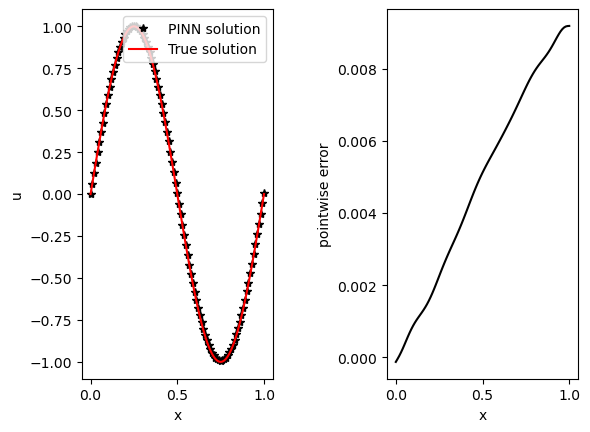

In [3]:
import matplotlib.pyplot as plt
import math

pi = tf.constant(math.pi)

def f(x):
    return -4*pi*pi*tf.math.sin(2*pi*x)

def exact_soln(x):
    return np.sin(2*np.pi*x) 

bc = 2*pi

x, u, _ = PINN_solve(f, bc)
u_true = exact_soln(x)

fig, ax = plt.subplots(1,2)
ax[0].plot(x,u,'k*',label='PINN solution')
ax[0].plot(x,u_true,'r',label='True solution')
ax[0].legend(loc='upper right')
ax[0].set_xlabel('x')
ax[0].set_ylabel('u')

ax[1].plot(x,u-u_true,'k-')
ax[1].set_xlabel('x')
ax[1].set_ylabel('pointwise error')
plt.subplots_adjust(wspace=0.6) 

We observe that the PINN solution is very close to the true solution, with pointwise errors generally less than 1%. 

`deepxde` outputs information about the loss at the training points and the test points every 1000 epochs. The three values printed for each correspond to the PDE, left boundary condition and right boundary condition components of the loss. With `use_best_test_loss` equal to `True` in the solver, the model corresponding to the smallest test loss (PDE component) will be returned. 

## Step 5: Error norm

In the code verification notebook we discussed how the appropriate norm for characterizing the numerical error depends on the theoretical results available for the method. For example, for finite elements the error should be measured using the integral $L_2$ or $H^1$ norms. For PINNs, while error theory does exist (<a href="#ref-Shin2020">Shin, 2020</a>, <a href="#ref-DeRyck2022">DeRyck, 2022</a>,<a href="#ref-Mishra2023">Mishra, 2023</a>), there is a lack of theory providing practical expected rates of convergence. 

Therefore, we can choose error norms based on other considerations. Two possibilities are the discrete $l_2$ and $l_\infty$ norms:
\begin{align*}
\|u - u_\textrm{true}\|_2 &= \frac{1}{N^{1/2}}\left(\Sigma_{i=1}^{N} \left(u(x_i) - u_\textrm{true}(x_i)\right)^2\right)^{1/2}\\
\|u - u_\textrm{true}\|_\infty &= \text{max}_{i=1..N} \left|u(x_i) - u_\textrm{true}(x_i)\right|
\end{align*}
Here, the $x_i$, $i=1,\ldots,N$ is a fixed uniform grid across the domain, **not the collocation points**, since these could vary in the convergence analysis and the PINN solve explicitly enforces the governing equation at the collocation points, so it is important that the norm measures the error at other locations. The scale factor $N^{-1/2}$ in the discrete $l_2$ norm ensures the norm approximates the continuous $L_2$ norm as $N$ gets large, rather than tending to $\infty$. In the below convergence study we will use $N=1000$.


## Step 6: Numerical error convergence study

The next step of the workflow is to perform a convergence analysis. **Important note:** for PINNs (and other neural networks) 'convergence' usually refers to convergence of the loss during training. We will refer to that  concept as 'training convergence', and in this notebook 'convergence' refers to convergence of the numerical solution to the true solution as numerical parameters are varied. 

For (time-independent) FEM, there was one parameter, $h$, that was varied. The error theory provided expected orders of convergence in the error norms as a function of $h$. However, for PINNs there is no direct, single equivalent of $h$. For FEM, decreasing $h$ has two effects. First, it increases the size of the approximation space, that is, the function space the numerical solutions reside in. For example, decreasing $h$ for linear elements means the solution can be better approximated by a piece-wise linear function. Second, it reduces quadrature (integration) error, since the integrals are computed in smaller elements. For the PINN, the size of the approximation space is determined by the network architecture, i.e. the number of layers and numbers of neurons per layer. The universal approximation theory for neural networks states that any function (satisfying certain conditions) can be approximated arbitrarily well by some sufficiently large neural network, but larger architectures may be needed to achieve very small numerical error. On the other hand, the analog of reducing FEM quadrature error is increasing the number of collocation points (training points), which increases the number of points the PDE is enforced at. 

Overall, while the number of collocation points will need to be increased in the convergence analysis, convergence may eventually be limited by the fixed architecture being unable to approximate the true solution arbitrarily well. However, increasing the network size (whether through number of layers, neurons per layer, or both) could lead to overfitting (which could be assessed via the test loss) or challenges in obtaining training convergence.

The PINN was run using `num_colloc_points` of $[10,100,1000,10000]$, `num_layers` of $[2,4]$ and `neurons_per_layer` of $[5,10,20]$. The solution training loss (PDE component), test loss (PDE solution), $l_2$ error and $l_{\infty}$ error were saved to file. The following settings were used: `num_epochs=100000`, collocation points randomly sampled each epoch, learning rate decay switched on, and the model corresponding to the smallest test loss  saved as the final result. All results have been previously computed and are saved in the `../saved_results` folder. The code used to generate these results can be found in `src/generate_PINN_error_convergence_results.py`.

Below we load these pre-computed results and plot the convergence as function of number of collocation points, for each of the six architectures. The lines are labeled by the total number of trainable parameters in the network, equal to $N_n(N_l+2) + N_nN_l (N_l-1)+1$, where $N_l $ is the number of layers and $N_n$ the number of nodes per layer. 

num_layers   nodes_per_layer   num_trainable_params
2             5                46
2             10                141
2             20                481
4             5                106
4             10                361
4             20                1321


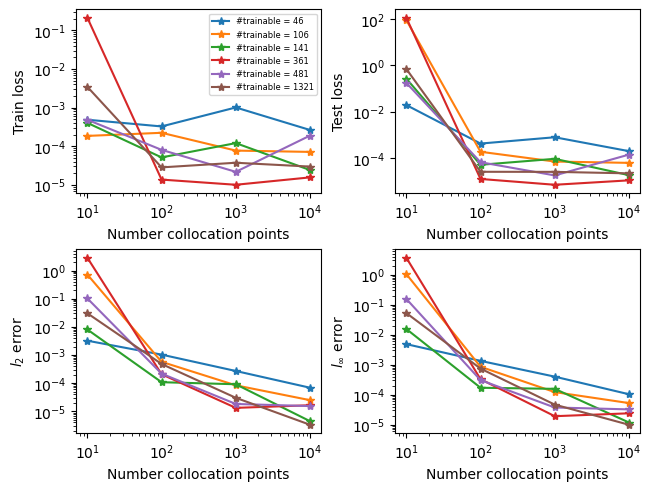

In [4]:
# First, print out the relationship between number of trainable parameters and num layers/neurons per layer, to help interpret the figure
import itertools
num_layers = [2,4]
neurons_per_layer = [5,10,20]
print(f"num_layers   nodes_per_layer   num_trainable_params")
for it in itertools.product(num_layers,neurons_per_layer):
    Nl = it[0]
    Nn = it[1]
    Nt = Nn*(Nl+2) + Nn*Nn*(Nl-1) + 1
    print(f"{Nl}             {Nn}                {Nt}")

# plot the actual results
from PINN_error_convergence import PINN_convergence_plots
df = pd.read_csv("../saved_results/MMS1_traindist_pseudo_usebesttest_true_lrdecay_true_epochs_100000.csv")
PINN_convergence_plots(df)

Because the $l_2$ and $l_{\infty}$ errors display essentially identical trends, we focus only on $l_2$ error in the following discussion. Note that unlike the FEM verification in the code verification notebook, performing this systematic convergence studies for a PINNs is computationally expensive, even for a simple 1D problem. 

For most architectures, the solution $l_2$ error decreases monotonically as the number of collocation points increases. However the trends do not clearly align with a linear relationship on a log-log scale (except for the smallest network), as is typically observed in FEM. In addition, two of the six architectures show stagnation at the greatest `num_colloc_points`, consistent with a lack of training convergence, despite the large number of epochs used.

For the finite element solver in the code verification notebook, the error could be reduced to near machine precision using a sufficiently refined mesh, and the theoretical order of convergence was observed. These results highlight the challenges in generating comparable results for PINNs. To further explore the impact of solver settings on the results, we repeated the convergence analysis with the following: (i) stopping after 10000 epochs instead of 100000; (ii) using uniform collocation points instead of randomly re-sampled; (iii) not saving and restoring the best performing model based on test loss; (iv) fixed learning rate instead of halving every 1000 epochs. We also applied the PINN solver on a second MMS-derived test problem with solution $u(x) = e^{-(x-1/2)^2} - e^{-1/4}$. The results of these convergence analyses are loaded and plotted in the following:


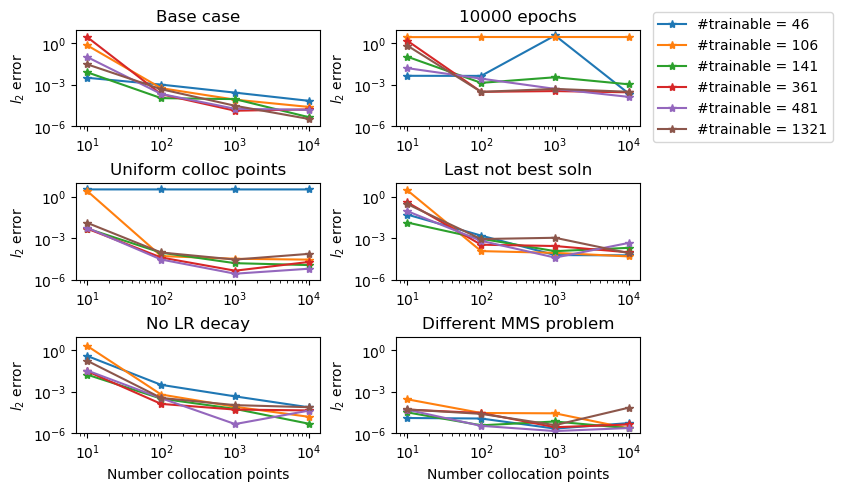

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df1 = pd.read_csv("../saved_results/MMS1_traindist_pseudo_usebesttest_true_lrdecay_true_epochs_100000.csv")
df2 = pd.read_csv("../saved_results/MMS1_traindist_pseudo_usebesttest_true_lrdecay_true_epochs_10000.csv")
df3 = pd.read_csv("../saved_results/MMS1_traindist_uniform_usebesttest_true_lrdecay_true_epochs_100000.csv")
df4 = pd.read_csv("../saved_results/MMS1_traindist_pseudo_usebesttest_false_lrdecay_true_epochs_100000.csv")
df5 = pd.read_csv("../saved_results/MMS1_traindist_pseudo_usebesttest_true_lrdecay_false_epochs_100000.csv")
df6 = pd.read_csv("../saved_results/MMS2_traindist_pseudo_usebesttest_true_lrdecay_true_epochs_100000.csv")

fig, ax = plt.subplots(3,2,constrained_layout=True)
ax = ax.flatten()   # turn 2D array into 1D list

dfs = [df1, df2, df3, df4, df5,df6]
titles = ['Base case','10000 epochs','Uniform colloc points','Last not best soln','No LR decay','Different MMS problem']

for i, (df, axis) in enumerate(zip(dfs, ax)):
    num_trainable_parameters_list = np.unique(df['num_trainable_params'].values)
    for ntp in num_trainable_parameters_list:
        df_restricted = df[df['num_trainable_params']==ntp]
        axis.loglog(df_restricted['num_colloc'], df_restricted['err_l2'], '*-', label = f"#trainable = {ntp}")        
        axis.set_ylabel("$l_2$ error")
        axis.set_ylim([1e-6,10.0])
        axis.set_title(titles[i])

        
ax[4].set_xlabel("Number collocation points")
ax[5].set_xlabel("Number collocation points")

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.0, 1.0), loc="upper left")

We see that:
 * Training duration: reducing the maximum number of epochs from 100000 to 10000 resulted in much larger final errors and pronounced stagnation, even for smaller architectures. This shows that sufficiently long training is essential, with training error dominating otherwise.
 * Collocation point sampling: Using uniformly sampled collocation points, instead of resampling randomly each epoch, also caused earlier stagnation.
 * When the option to save the best performing model was disabled, stagnation and higher overall errors were observed. This emphasizes the importance of model selection during training.
 * Learning rate decay: switching off learning rate decay produced smaller effects, but errors were still somewhat larger overall.
 * For the alternative MMS test problem, the solver reached relatively low error solutions even for small numbers of collocation points. As a result, the linear-like convergence trends were less apparent.

Overall, these results demonstrate the difficulty of demonstrating PINN convergence in a manner comparable to FEM. Lack of error theory, and challenges in robust training, suggest quantifying error in a manner similar to FEM may sometimes not be feasible. These observations motivate a **PINN-specific approach to code verification**. A potential alternative strategy is to structure a PINN solver so that it can solve both a simplified PDE and the full PDE of interest. The simplified problem would be used to verify the shared PINN infrastructure through MMS, using absolute error checks and empirical convergence studies to the extent possible. The full PDE implementation could undergo detailed code inspection, targeted unit tests and perhaps MMS verification and absolute error checks. See the supporting publication for further discussion.

# Calculation verification of PINN solvers

The challenges identified for code verification above emphasize the importance of performing calculation verification when a PINN solver is used. We conclude this notebook with three observations regarding PINN calculation verification.

## Low numerical error for one problem does not imply low numerical error for closely related problems

The following figures plot numerical error in the two MMS problems against each other, across all the PINN configurations (i.e., varying architecture and number of collocation points). The errors are not well correlated. In contrast, for the finite element method there is perfect correlation as expected (here the different entries correspond to different choices of $h$). This illustrates that choices of architecture, number of collocation points, and training settings, for one problem may not necessarily be the best choices when for a different problem (even when the change is as simple as changing the load and the boundary condition). Estimating numerical error based on numerical errors observed in related problems may not be a reliable approach for PINNs.

Text(0.5, 1.0, '$l_2$ error')

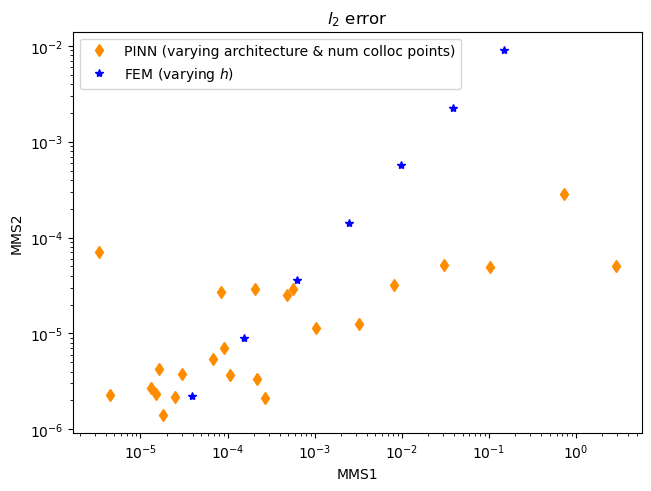

In [6]:
df_pinn_mms1 = pd.read_csv("../saved_results/MMS1_traindist_pseudo_usebesttest_true_lrdecay_true_epochs_100000.csv")
df_pinn_mms2 = pd.read_csv("../saved_results/MMS2_traindist_pseudo_usebesttest_true_lrdecay_true_epochs_100000.csv")

df_fem_mms1 = pd.read_csv("../saved_results/fem_convergence_MMS1.csv")
df_fem_mms2 = pd.read_csv("../saved_results/fem_convergence_MMS2.csv")

fig, ax = plt.subplots(1,1,constrained_layout=True)
ax.loglog(df_pinn_mms1['err_l2'],df_pinn_mms2['err_l2'],color='darkorange',marker='d', ls='',label = "PINN (varying architecture & num colloc points)")
ax.loglog(df_fem_mms1['err_l2'],df_fem_mms2['err_l2'],color='blue',marker='*', ls='', label = "FEM (varying $h$)")
ax.legend(loc='upper left')
ax.set_xlabel('MMS1')
ax.set_ylabel('MMS2')
ax.set_title('$l_2$ error')

## Care should be taken if computing Richardson extrapolated values and Grid Convergence Index. 

*In theory*, a PINN convergence study could be performed varying the collocation points only and holding other parameters constant, and the functions  in the `calcverif` module (see `PdeCalculationVerification.ipynb`) could be used to compute the observed order of convergence, Richardson extrapolated value, and Grid Convergence Index. However, the challenges demonstrated above in robust training across all solves, the lack of theory supporting rates of convergence for PINNs, possible network approximation error, and the fact that GCI was developed based on empirical findings with traditional numerical methods, all limit reliability of Richardson extrapolated value and any GCI-based bounds. 

## Care should be taken if using test loss as error estimate

One advantage of PINNs over the basic finite element method is information provided by the test loss, which characterizes how well the PDE and boundary conditions are satisfied at a set of points independent of the collocation (training) points. The `PINN_solver` implemented above uses 100 test points, which are equally spaced in the domain. During training, three components of the test loss are printed after each iteration, representing the PDE residual across the internal test points, and the two boundary condition errors. The value of the test loss, after training is complete, can be used as a surrogate for model accuracy. If the test loss is large, the numerical solution will likely be poor, perhaps due to overfitting if the training loss is small but test loss is large. However, it is important to avoid over-reliance on test loss as an estimate of numerical error. Test loss is not perfectly correlated with actual numerical error, as shown in the following figures which plots test loss (PDE component) vs $l_2$ errors for the two MMS problems. For some values of the test loss (e.g., ~$10^{-4}$ for MMS1 and ~$10^{-7}$ for MMS2), the actual $l_2$ numerical error can vary across two orders of magnitude.


Text(0.5, 1.0, 'MMS Problem 2')

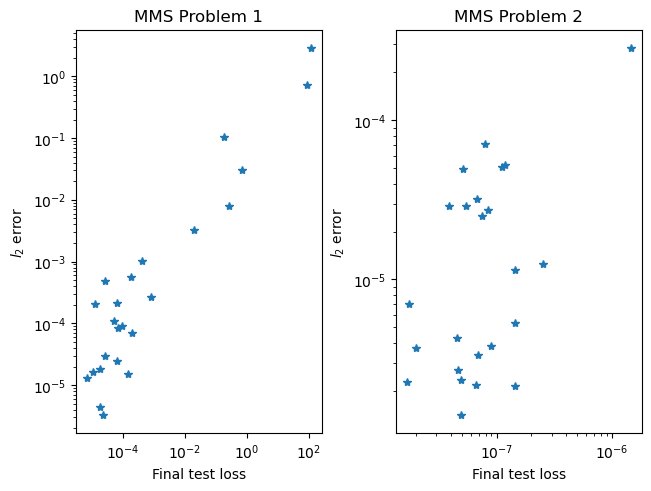

In [7]:
df1 = pd.read_csv("../saved_results/MMS1_traindist_pseudo_usebesttest_true_lrdecay_true_epochs_100000.csv")
df2 = pd.read_csv("../saved_results/MMS2_traindist_pseudo_usebesttest_true_lrdecay_true_epochs_100000.csv")

fig, ax = plt.subplots(1,2,constrained_layout=True)
ax[0].loglog(df1['loss_test'],df1['err_l2'],'*')
ax[0].set_xlabel('Final test loss')
ax[0].set_ylabel('$l_2$ error')
ax[0].set_title('MMS Problem 1')

ax[1].loglog(df2['loss_test'],df2['err_l2'],'*')
ax[1].set_xlabel('Final test loss')
ax[1].set_ylabel('$l_2$ error')
ax[1].set_title('MMS Problem 2')


# References
<ul>
  <li id="ref-DeRyck2022">T. De Ryck, S. Mishra, Error analysis for physics-informed neural networks (PINNs) approximating Kolmogorov PDEs, Advances in Computational Mathematics, 2022</li> 
  <li id="ref-Grossmann2024">T. Grossmann et al., Can physics-informed neural networks beat the finite element method?, IMA Journal of Applied Mathematics, 2024</li>
  <li id="ref-Karniadakis2021">G. E. Karniadakis et al., Physics-informed machine learning, Nature Reviews Physics, 2021</li>
  <li id="ref-Lu2021DeepXDE">L. Lu, X. Meng, Z. Mao, G. Karniadakis, DeepXDE: A deep learning library for solving differential equations, SIAM Review, 2021</li>
  <li id="ref-Mishra2023">S. Mishra, R. Molinaro, Estimates on the generalization error of physics-informed neural networks for approximating PDEs, IMA Journal of Numerical Analysis, 2023</li>
  <li id="ref-Raissi2019">M. Raissi, P. Perdikaris, G. Karniadakis, Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations, Journal of Computational physics, 2019</li>
  <li id="ref-Shin2020">Y. Shin, J. Darbon, G. Karniadakis, On the convergence of physics-informed neural networks for linear second-order elliptic and parabolic type PDEs, Communications in Computational Physics, 2020</li>
  <li id="ref-Zhongkai2024PINNacle">H. Zhongkai et al., PINNacle: A comprehensive benchmark of physics-informed neural networks for solving PDEs, Advances in Neural Information Processing Systems, 2024</li>
</ul>
